In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(train.info())
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.

In [3]:
print(train.columns.values)
# As we can guess, except for PassengerId and Ticket all the features would contribute to 
# whether the person survived or not. Thus we can drop the 2 columns from train

columns = ['PassengerId', 'Ticket']
train = train.drop(columns, axis=1)
test = test.drop(columns, axis=1)
train.head(3)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S


In [4]:
# We first find the features which have null values 
print(train.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64


In [5]:
# As we can see, Age, Cabin and Embarked have values which are null. Since Embarked has just 2 missing, 
# we shall give it a value of 'S'. Lets first allot these missing cells a numerical value
datasets = [train, test]

for dataset in datasets:
#     Handles missing values in Age by filling them with random number between mean-std and mean+std
    mean = dataset["Age"].mean()
    std = dataset["Age"].std()
    age_null_count = dataset["Age"].isnull().sum()
    age_null_random = np.random.randint(mean - std, mean + std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random
    dataset['Age'] = dataset['Age'].astype(int)
    
#     Handles missing values in Cabin by giving a value of 1 if present else 0
    dataset["Cabin"] = dataset["Cabin"].apply(lambda x: 0 if type(x)!=str else 1)
    
    dataset["Embarked"] = dataset["Embarked"].fillna('S')

# Now we shall convert the features into numerical form by mapping 
for dataset in datasets:
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)
    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


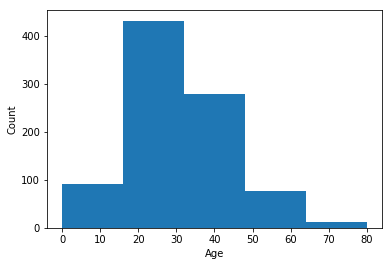

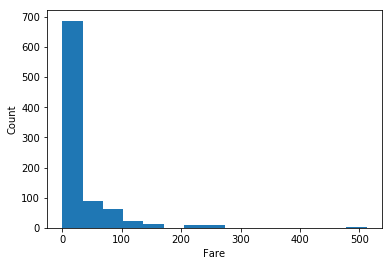

In [6]:
plt.hist(train.Age, bins=5)
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

plt.hist(train.Fare, bins=15)
plt.xlabel("Fare")
plt.ylabel("Count")
plt.show()
# Thus we can see that these 2 features can be split up into several parts

In [7]:
for dataset in datasets:
#     Splitting Fare
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
#     Splitting Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 20), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 25), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <= 32), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 40), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 50), 'Age'] = 5
    dataset.loc[dataset['Age'] > 50, 'Age'] = 6

# As we can see the distribution is done reasonably well and we have split it evenly into classess
print(train['Fare'].value_counts())
print(train['Age'].value_counts())

# To recheck if we have any null values or different data types
print(train.info())
print(train.isnull().sum())

2    229
0    223
3    222
1    217
Name: Fare, dtype: int64
3    192
4    179
2    148
0    112
5    100
1     96
6     64
Name: Age, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null int64
Age         891 non-null int64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null int64
Cabin       891 non-null int64
Embarked    891 non-null int64
dtypes: int64(9), object(1)
memory usage: 69.7+ KB
None
Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64


In [8]:
print("Titles in Train")
train['title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
print(train['title'].value_counts(),'\n')

print("Titles in Test")
test['title'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
print(test['title'].value_counts())

Titles in Train
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Lady          1
Don           1
Countess      1
Capt          1
Mme           1
Ms            1
Sir           1
Jonkheer      1
Name: title, dtype: int64 

Titles in Test
Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Dr          1
Ms          1
Name: title, dtype: int64


In [9]:
# As we can see, we can classify the titles of the people based on their frequency
titles = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Other':5}
for dataset in datasets:
    dataset['title'] = dataset['title'].replace(['Dr', 'Rev','Col','Major','Sir','Don','Jonkheer','Capt','Lady','Countess','Dona'], 'Other')
    dataset['title'] = dataset['title'].replace(['Ms', 'Mlle'],'Miss')
    dataset['title'] = dataset['title'].replace('Mme','Mrs')
    dataset['title'] = dataset['title'].map(titles)
    dataset['title'] = dataset['title'].fillna(0)

print(train['title'].value_counts())

# Now that we have noted the titles, the names column doesn't hold any futher value so we can drop them
train = train.drop('Name', axis=1)
test = test.drop('Name', axis=1)

1    517
2    185
3    126
4     40
5     23
Name: title, dtype: int64


In [10]:
# We can also find a correlation between the passenger being alone, or having relatives
# so we can create 2 new features
datasets = [train, test]
for dataset in datasets:
    dataset['familySize'] = dataset['Parch']+dataset['SibSp']+1
    dataset.loc[dataset['familySize']>1, 'isAlone'] = 0
    dataset.loc[dataset['familySize']==1, 'isAlone'] = 1
    dataset['isAlone'] = dataset['isAlone'].astype(int)

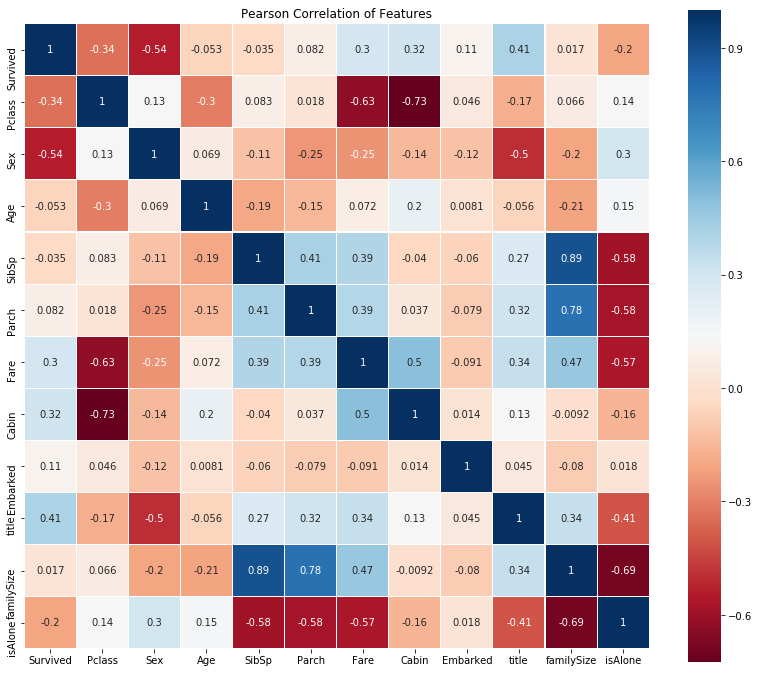

In [11]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features')
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, annot=True)

# This heatmap shows the correlation of the features with each other. As we can see, except for the high
# correlation of SibSp and Parch with familySize, most of the other features are not highly correlated with each other.
# Thus we can drop SibSp and Parch in our datasets

train = train.drop('SibSp', axis=1)
train = train.drop('Parch', axis=1)
test = test.drop('SibSp', axis=1)
test = test.drop('Parch', axis=1)

In [12]:
test.head(3)

,Pclass,Sex,Age,Fare,Cabin,Embarked,title,familySize,isAlone
0,3,1,4,0,0,2,1,1,1
1,3,0,5,0,0,0,3,2,0
2,2,1,6,1,0,2,1,1,1


In [13]:
train_x = train.drop('Survived', axis=1)
train_y = train['Survived']
test_x = test

# We shall further divide the training set to form a new cross validation set to find the accuracy
# and to cross check if the prediction model has overfit or underfit the train data
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=1)
train_y

301    1
309    1
516    1
120    0
570    1
730    1
228    0
563    0
311    1
613    0
194    1
185    0
339    0
274    1
875    1
852    0
61     1
277    0
427    1
676    0
493    0
433    0
571    1
773    0
135    0
248    1
345    1
765    1
134    0
507    1
      ..
86     0
478    0
503    0
753    0
215    1
580    1
562    0
398    0
668    0
490    0
252    0
468    0
357    0
254    0
276    0
178    0
281    0
390    1
508    0
749    0
583    0
129    0
144    0
847    0
645    1
715    0
767    0
72     0
235    0
37     0
Name: Survived, Length: 712, dtype: int64

In [14]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(train_x, train_y)
log_reg_predictions = log_reg.predict(train_x)
log_reg_accuracy = round(log_reg.score(train_x, train_y)*100, 2)
print("Accuracy: " ,log_reg_accuracy)

print("Precision score: ", precision_score(train_y, log_reg_predictions))
print("Recall score: ", recall_score(train_y, log_reg_predictions))
print("F Score: ", f1_score(train_y, log_reg_predictions))

Accuracy:  82.87
Precision score:  0.7816091954022989
Recall score:  0.758364312267658
F Score:  0.7698113207547169


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_x, train_y)

random_forest_predictions = random_forest.predict(train_x)

random_forest_accuracy = round(random_forest.score(train_x, train_y) * 100, 2)
print("Accuracy: " ,random_forest_accuracy)

print("Precision score: ", precision_score(train_y, random_forest_predictions))
print("Recall score: ", recall_score(train_y, random_forest_predictions))
print("F Score: ", f1_score(train_y, random_forest_predictions))

Accuracy:  91.99
Precision score:  0.9274193548387096
Recall score:  0.8550185873605948
F Score:  0.8897485493230173


In [16]:
# Linear Support Vector Machine
linear_svc = LinearSVC()
linear_svc.fit(train_x, train_y)

linear_svc_predictions = linear_svc.predict(train_x)

linear_svc_accuracy = round(linear_svc.score(train_x, train_y) * 100, 2)
print("Accuracy: " ,linear_svc_accuracy)

print("Precision score: ", precision_score(train_y, linear_svc_predictions))
print("Recall score: ", recall_score(train_y, linear_svc_predictions))
print("F Score: ", f1_score(train_y, linear_svc_predictions))

Accuracy:  82.72
Precision score:  0.7807692307692308
Recall score:  0.7546468401486989
F Score:  0.7674858223062383


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [17]:
# KNN Neighbours Classification
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_x, train_y)  
knn_predictions = knn.predict(train_x)  
knn_accuracy = round(knn.score(train_x, train_y) * 100, 2)
print("Accuracy: " ,knn_accuracy)

print("Precision score: ", precision_score(train_y, knn_predictions))
print("Recall score: ", recall_score(train_y, knn_predictions))
print("F Score: ", f1_score(train_y, knn_predictions))

Accuracy:  87.36
Precision score:  0.8683127572016461
Recall score:  0.7843866171003717
F Score:  0.82421875


In [18]:
results_train = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest'],
    'Score': [linear_svc_accuracy, knn_accuracy, log_reg_accuracy, 
              random_forest_accuracy],
    'F Score': [f1_score(train_y, linear_svc_predictions), f1_score(train_y, knn_predictions),
                f1_score(train_y, log_reg_predictions),f1_score(train_y, random_forest_predictions)],
    'Precisions': [precision_score(train_y, linear_svc_predictions), precision_score(train_y, knn_predictions),
                precision_score(train_y, log_reg_predictions),precision_score(train_y, random_forest_predictions)],
    'Recall': [recall_score(train_y, linear_svc_predictions), recall_score(train_y, knn_predictions),
                recall_score(train_y, log_reg_predictions),recall_score(train_y, random_forest_predictions)]})
result_train_df = results_train.sort_values(by='Score', ascending=False)
result_train_df

,Model,Score,F Score,Precisions,Recall
3,Random Forest,91.99,0.889749,0.927419,0.855019
1,KNN,87.36,0.824219,0.868313,0.784387
2,Logistic Regression,82.87,0.769811,0.781609,0.758364
0,Support Vector Machines,82.72,0.767486,0.780769,0.754647


In [19]:
knn_predictions

array([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,

In [20]:
# As we can see, the accuracy of Random Forest Classifier, is highest, with a pretty good score of precision
# and recall giving a the highest F score

random_forest_val = RandomForestClassifier(n_estimators=100)
random_forest_val.fit(val_x, val_y)

random_forest_predictions_val = random_forest_val.predict(val_x)

random_forest_accuracy_val = round(random_forest_val.score(val_x, val_y) * 100, 2)
print("Accuracy: " ,random_forest_accuracy_val)

print("Precision score: ", precision_score(val_y, random_forest_predictions_val))
print("Recall score: ", recall_score(val_y, random_forest_predictions_val))
print("F Score: ", f1_score(val_y, random_forest_predictions_val))

Accuracy:  96.09
Precision score:  0.9852941176470589
Recall score:  0.9178082191780822
F Score:  0.9503546099290779


In [21]:
# Since we get a very good score for the cross validation set as well, we can successfully consider that
# the data hasn't been overfit or underfit and we can run the same classifier on the the test data

random_forest_prediction_test = RandomForestClassifier(n_estimators=100)
random_forest_prediction_test.fit(train_x, train_y)
test_y = random_forest_prediction_test.predict(test_x)
test_y

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [23]:
PassengerId=[]
Predictions=[]
test_x = pd.read_csv('test.csv')
for index, row in test_x.PassengerId.iteritems():
    PassengerId.append(row)
    Predictions.append(test_y[index])

result_df = pd.DataFrame({'PassengerId': PassengerId, 'Survived': Predictions})
result_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
